In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import seaborn as sns
import warnings 
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from adjustText import adjust_text
import matplotlib as mpl

#Read data
df = pd.read_csv('Footballdata/Others/GermanyvsJapan2.csv', encoding='latin-1')

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#length of passes
df['passlength'] = np.sqrt(np.square(df['endX']-df['x']) + np.square(df['endY']-df['y']))

#New variables to find progressive passes
df['beginning'] = np.sqrt(np.square(120-df['x'])+np.square(40-df['y']))
df['end'] = np.sqrt(np.square(120-df['endX'])+np.square(40-df['endY']))
df['progressive'] = [(df['end'][x]) / (df['beginning'][x]) <.75 for x in range(len(df.beginning))]

#Variable for Passes that goes into Penalty Area   \\ (df['outcomeType/displayName'] == 'Successful') & 
df['penalty_pass']= np.where((df['endY'].between(17.5,62.5)) & ((df['endX']> 103) & 
                             ((df['x']< 119))), 1, 0)

#remove substitution events,challenges & formation change
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'Challenge')]

#remove the records of a failed aerial, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type/displayName'] == 'Aerial') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

#Identify the passers and recipients
df['passer'] = df['playername']
df['recipient'] = df['playername'].shift(-1)

#find if the next event is by the same team
df['teamId_next'] = df['teamId'].shift(-1)

#Finding previous event to filter out setpieces
df['prevevent'] = df['type/displayName'].shift(1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type/displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type/displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]

In [2]:
#main df includes all passes; progressive_pass includes successful ones, which are going to be filtered for progressive only
df = df[df['type/displayName']=='Pass']

#Take out passes inside the box

#Take out corners
df = df.loc[(df['x'] < 119.1)]

progressive_pass = df[df['outcomeType/displayName']=='Successful']

#Filter to make sure recipients are from the same team
progressive_pass = progressive_pass.loc[(progressive_pass['teamId_next'] == progressive_pass['teamId'])]

#Filter for progressive passes OR passes into penalty area and further from starting point
progressive_pass = progressive_pass.loc[(progressive_pass['progressive']==True) | (progressive_pass['penalty_pass'] == 1) & 
                                        (progressive_pass['x'] < progressive_pass['endX'])]

#Take out passes inside the box
progressive_pass = progressive_pass.loc[~((progressive_pass['y'].between(17,64) & (progressive_pass['x'] > 103)))]

#progressive_pass.head()

In [3]:
#Import Grid
#xT = pd.read_csv("xTGrid.csv", header=None)
EPV = pd.read_csv("EPVGrid.csv", header=None)
EPV = np.array(EPV)
EPV_rows, EPV_cols = EPV.shape

#Creating Bins
progressive_pass['x1_bin'] = pd.cut(progressive_pass['x'], bins=EPV_cols, labels=False)
progressive_pass['y1_bin'] = pd.cut(progressive_pass['y'], bins=EPV_rows, labels=False)
progressive_pass['x2_bin'] = pd.cut(progressive_pass['endX'], bins=EPV_cols, labels=False)
progressive_pass['y2_bin'] = pd.cut(progressive_pass['endY'], bins=EPV_rows, labels=False)

progressive_pass['start_zone_value'] = progressive_pass[['x1_bin', 'y1_bin']].apply(lambda x: EPV[x[1]][x[0]], axis=1)
progressive_pass['end_zone_value'] = progressive_pass[['x2_bin', 'y2_bin']].apply(lambda x: EPV[x[1]][x[0]], axis=1)

progressive_pass['EPV_Pass'] = progressive_pass['end_zone_value'] - progressive_pass['start_zone_value']
progressive_pass['EPV_Receive'] = progressive_pass['end_zone_value']

progressive_pass = progressive_pass[['playername','teamId','recipient','teamId_next','EPV_Pass','EPV_Receive']]
#progressive_pass = progressive_pass.loc[(progressive_pass['playername'] == 'Marco Reus')]
progressive_pass.head()

,playername,teamId,recipient,teamId_next,EPV_Pass,EPV_Receive
46,Jamal Musiala,Germany,Serge Gnabry,Germany,-0.0009,0.0183
50,David Raum,Germany,Kai Havertz,Germany,0.0068,0.0327
53,Kai Havertz,Germany,Thomas Müller,Germany,0.0509,0.0875
85,Joshua Kimmich,Germany,Jamal Musiala,Germany,0.0000,0.0107
94,Hiroki Sakai,Japan,Takefusa Kubo,Japan,0.0114,0.0373


In [4]:
EPV1 = progressive_pass.groupby(['playername','teamId']).agg({'EPV_Pass':['sum']})
EPV1.columns = ['EPV_Pass']

#Creating a new dataframe to store everything, to get playername as a variable
EPVPass = EPV1['EPV_Pass'].to_frame(name='SUM').reset_index()
EPVPass.columns = ['Player','Team','EPV_Pass']
EPVPass = EPVPass.sort_values(by='EPV_Pass',ascending=False)

#Grouping the players with the sum of their EPV's from receives in the game
EPV2 = progressive_pass.groupby(['recipient','teamId_next']).agg({'EPV_Receive':['sum']})
EPV2.columns = ['EPV_Receive']

#Creating a new dataframe to store everything, to get playername as a variable
EPVReceive = EPV2['EPV_Receive'].to_frame(name='SUM').reset_index()
EPVReceive.columns = ['Player','Team','EPV_Receive']
EPVReceive = EPVReceive.sort_values(by='EPV_Receive',ascending=False)

#Merge
result = pd.merge(EPVPass, EPVReceive, how='outer')
result.fillna(0, inplace=True)

#Setting up quartiles
q1_Pass = result['EPV_Pass'].quantile(0.2)
q2_Pass = result['EPV_Pass'].quantile(0.5)
q3_Pass = result['EPV_Pass'].quantile(0.8)

q1_Receive = result['EPV_Receive'].quantile(0.2)
q2_Receive = result['EPV_Receive'].quantile(0.5)
q3_Receive = result['EPV_Receive'].quantile(0.8)

#Identify teams
t = []
for i in result.Team.unique():
    t.append(i)

squad1 = t[0]
squad2 = t[1]

result

,Player,Team,EPV_Pass,EPV_Receive
0,Ao Tanaka,Japan,0.4391,0.0368
1,Joshua Kimmich,Germany,0.2141,0.0345
2,David Raum,Germany,0.1547,0.4235
3,Mario Götze,Germany,0.0861,0.0000
4,Nico Schlotterbeck,Germany,0.0762,0.0186
5,Ilkay Gündogan,Germany,0.0686,0.0380
6,Yuto Nagatomo,Japan,0.0634,0.0000
7,Hiroki Sakai,Japan,0.0622,0.5140
8,Kai Havertz,Germany,0.0537,0.3135
9,Serge Gnabry,Germany,0.0439,0.3744


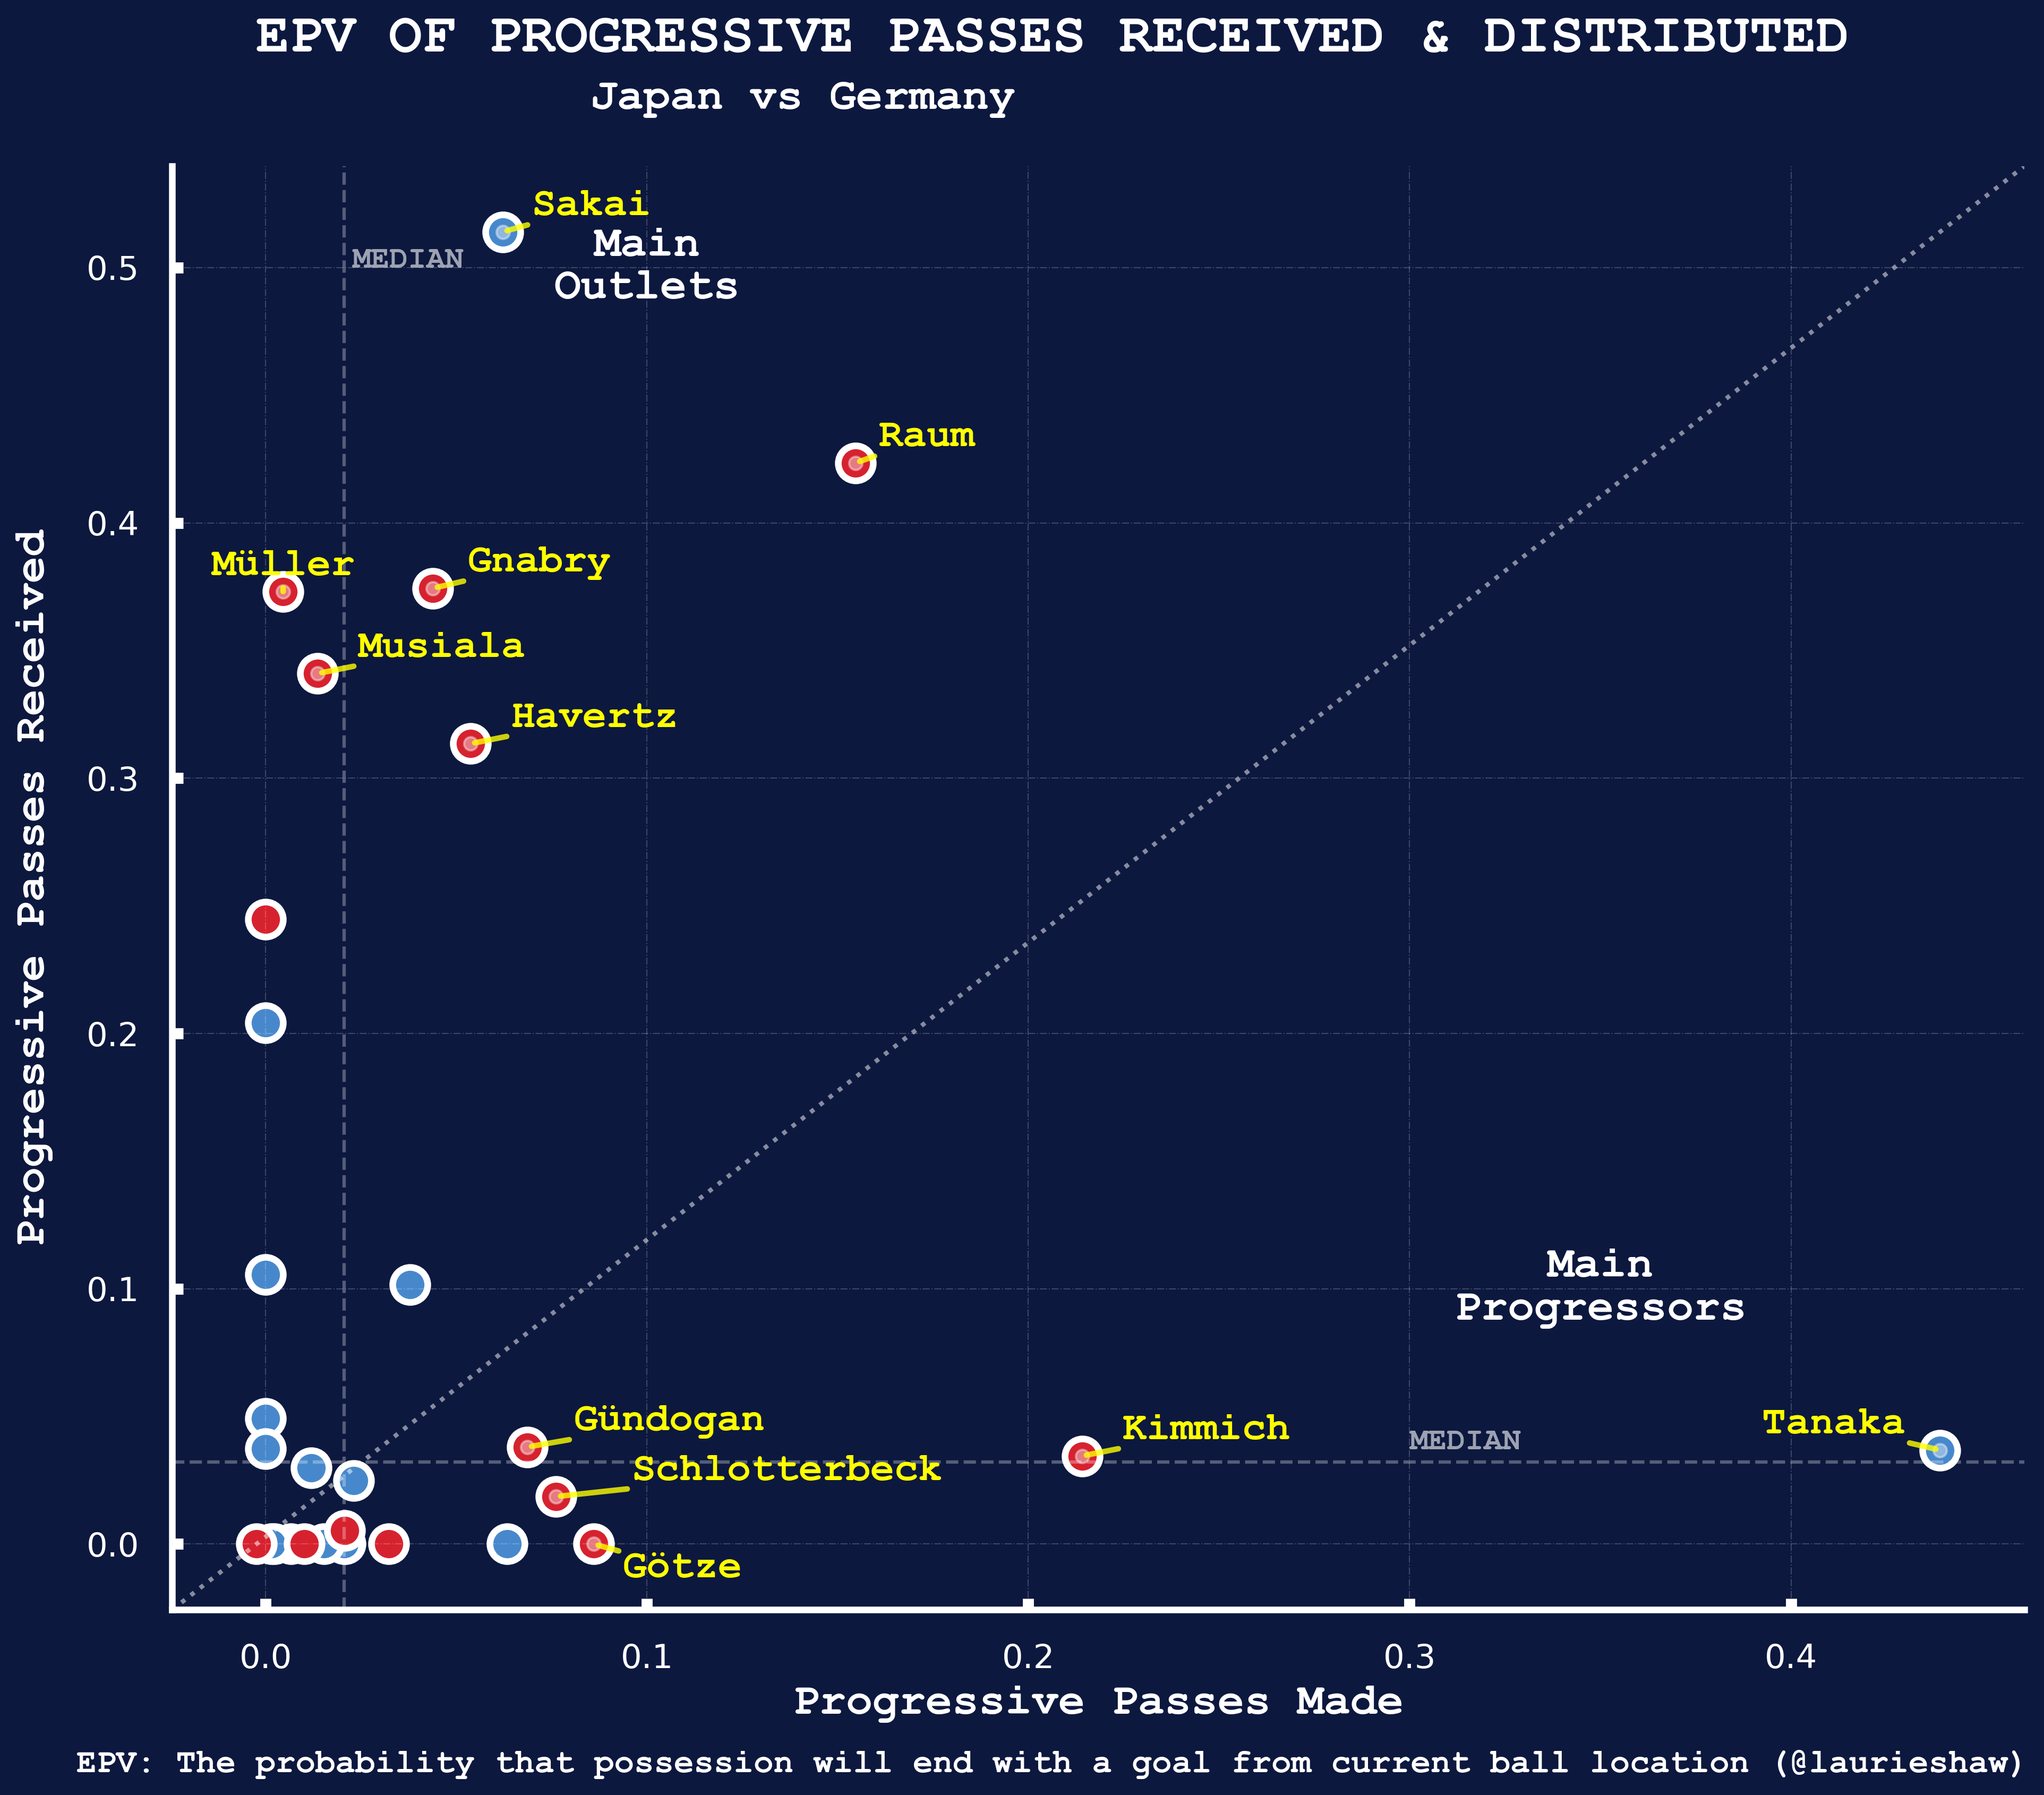

In [5]:
#Set color
homecolor = '#4788cc'
awaycolor = '#d6222f'

#Remove warning
pd.options.mode.chained_assignment = None

mpl.rcParams['figure.dpi'] = 300

#Figure Size 
fig, ax = plt.subplots(figsize=(15,12))
fig.set_facecolor('#0d183f')

#Grid
ax.grid(color='white', linestyle='-.', linewidth=0.5, alpha=0.2)
ax.set_facecolor('#0d183f')
ax.axhline(q2_Receive, c='w', alpha=0.3, ls='--')
ax.axvline(q2_Pass, c='w', alpha=0.3, ls='--')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='w', alpha=0.5, ls=':',lw=2)

#Plot
#Team 1
team1 = result[(result['Team'] == squad1)]
x, y = team1['EPV_Pass'].tolist(), team1['EPV_Receive'].tolist()
ax.scatter(x, y, c=homecolor, edgecolor='w', lw =3, s = 250)

#Team 2
team2 = result[(result['Team'] == squad2)]
x, y = team2['EPV_Pass'].tolist(), team2['EPV_Receive'].tolist()
ax.scatter(x, y, c=awaycolor, edgecolor='w', lw =3, s = 250)

#Setting labels
texts = []
for x, y, s in zip(result['EPV_Pass'], result['EPV_Receive'], result['Player']):
    if len(s.split())==1:
        name = s
    else:
        name = ' '.join(s.split()[1:])
        
    if x>q3_Pass or y>q3_Receive:
        ax.scatter(x, y, c='w', alpha = 0.4)
        texts.append(ax.text(x, y, name, fontdict=dict(color='yellow', size=18,fontfamily='Courier New',fontweight='bold')))
        
adjust_text(texts,force_points=0.2, force_text=0.2,
             expand_points=(-1.5,-1.5), expand_text=(0.5,0.5),
             arrowprops=dict(arrowstyle = '-', lw=2.5, color='yellow',alpha=0.8,zorder=3))

#Title
fig.text(0.16,0.94,'EPV of Progressive Passes Received & Distributed'.upper(),
         size = 25, color='w',weight='heavy',fontfamily='Courier New')
#fig.text(0.33,0.91, squad1 + ' vs '+ squad2 + ' || @chunhang7', size = 20,fontfamily='Courier New',fontweight='bold',color='w')

fig.text(0.3,0.91, squad1 + ' vs '+ squad2, size = 20, 
         fontfamily='Courier New',fontweight='bold',color='w')

#Labels
ax.set_ylabel('Progressive Passes Received', size=20, weight='bold',color='w',fontfamily='Courier New',labelpad = 15)
ax.set_xlabel('Progressive Passes Made',fontweight='bold', size=20,color='w',fontfamily='Courier New',labelpad = 5)

#Remove axes spines
for s in ['right','top']:
    ax.spines[s].set_visible(False)

#Set spine width & color
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

#Remove x,y Ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

#Add padding between axes and labels
ax.xaxis.set_tick_params(pad=15, width=5,length=5,direction='in',colors='w',labelsize=15)
ax.yaxis.set_tick_params(pad=15, width=5,length=5,direction='in',colors='w',labelsize=15)

#Captions
ax.text(0.1, 0.5,'Main\nOutlets', c='w', size=20,va='center',ha='center',fontfamily='Courier New',fontweight='bold')
ax.text(0.35, 0.1,'Main\nProgressors', c='w', size=20,va='center',ha='center',fontfamily='Courier New',fontweight='bold')
fig.text(0.085, 0.04, 'EPV: The probability that possession will end with a goal from current ball location (@laurieshaw)', 
         size = 15, fontfamily='Courier New',fontweight='bold',color='w')

#Median (horizontal first, vertical second)
ax.text(0.3, q2_Receive+0.005,'MEDIAN', size=14, fontfamily='Courier New',fontweight='bold', color='w',alpha=0.6)
ax.text(q2_Pass+0.002, 0.5,'MEDIAN', size=14, fontfamily='Courier New',fontweight='bold',color='w',alpha=0.6)

"""#Watermark
fig.text(0.89, 0.05, "Data via Opta", fontsize=14, color='#f5f201',ha='right', va='bottom', 
         alpha=0.6, fontweight='bold', fontfamily='Courier New')
fig.text(0.293, 0.05, "Inspired by @11tegen11", fontsize=14, color='#f5f201',ha='right', va='bottom', 
         alpha=0.6, fontweight='bold', fontfamily='Courier New')
"""
#plt.savefig("ChelseavsLiverpoolEPV1.png",dpi=300)
plt.show()